In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Placement

In [8]:
# res = np.load('../results/doubeline_2_enter_50_10000_popsize_50_order_inversion_20240827171221.npz', allow_pickle=True)
res = np.load('../results/doubeline_4_enter_50_10000_popsize_50_order_inversion_20240827201413.npz', allow_pickle=True)
layout_name = res['layout']
bsf_costs = np.max(res['bsf_costs'], axis=1)
pop_size = res['population_size']
machine_positions = res['machine_positions']
drug_names = res['machines_drug_names']

inlet_positions = res['inlet_positions']

gen_best_cost = res['gen_best_cost']
gen_best_perm = res['gen_best_perm'] # permutation of idxs of machines_drug_names
n_eval = res['n_eval']

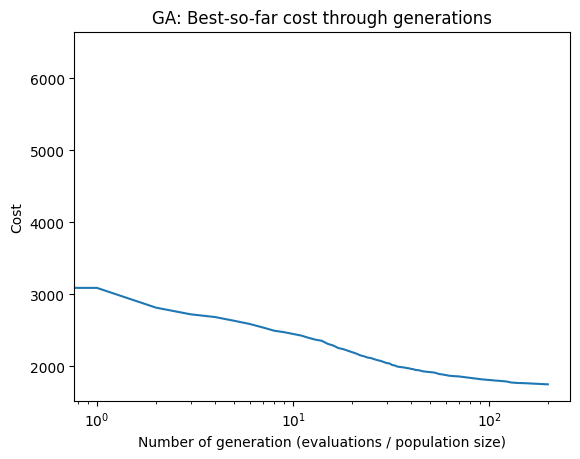

In [9]:
plt.plot(bsf_costs, label='Best cost')
plt.xscale('log')
plt.title('GA: Best-so-far cost through generations')
plt.xlabel('Number of generation (evaluations / population size)')
plt.ylabel('Cost')
plt.show()

In [10]:
def display_placement(permutation, drug_names, machine_positions):
    fig = plt.figure()
    ax = fig.add_subplot()
    # max size of x in machine_positions
    COORDINATE_X = max([x for x, y in machine_positions]) + 1
    COORDINATE_Y = max([y for x, y in machine_positions]) + 1
    restricted_area = np.zeros((COORDINATE_X, COORDINATE_Y))
    for i in range(len(machine_positions)):
        x, y = machine_positions[i]
        restricted_area[x, y] = 1
    for i in range(len(inlet_positions)):
        x, y = inlet_positions[i]
        restricted_area[x, y] = 2
    ax.imshow(restricted_area.transpose(), cmap='gray', alpha=0.1)
    
    plt.scatter(*zip(*machine_positions), c='r', s=100, marker='s', label='Machine')
    for p in inlet_positions:
        plt.scatter(*zip(p), c='b', s=100, marker='o', label='Exit')

    # ax.set_xticks(range(COORDINATE_X))
    # ax.set_yticks(range(COORDINATE_Y))

    for i in range(len(permutation)):
        drug_name = drug_names[int(permutation[i])]
        x = machine_positions[i][0]
        y = machine_positions[i][1]
        if x == 0: # left
            ha = 'right'
            rotation = 0
            va = 'center'
        elif x == COORDINATE_X-1: # right
            ha = 'left'
            rotation = 0
            va = 'center'
        elif y == COORDINATE_Y-1: # bottom
            ha = 'center'
            rotation = 90
            va = 'top'
        else: # top
            ha = 'center'
            rotation = 90
            va = 'bottom'
            
        ax.text(x, y, drug_name, ha=ha, va=va, rotation=rotation)
    # plt.legend() # Uncomment to show legend. It's overlapping with the text, so I commented it out.
    plt.show()

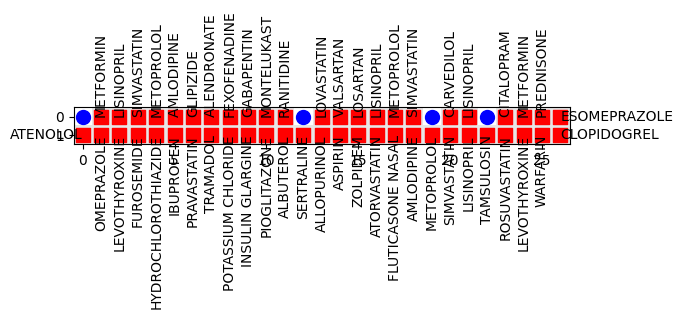

In [11]:
display_placement(gen_best_perm, drug_names, machine_positions)

# Generate patients with different capsule dosages


In [6]:
NUMBER_OF_PATIENTS = 50
DISPENSER_SPEED = 10 # tablets per second
TIME_BETWEEN_CAPSULES = 1 # seconds
NUMBER_OF_CAPSULES_PER_MOVER = 100

In [7]:
import pandas as pd
dosages = pd.read_csv('../drugs_dosing.csv', sep=';')
dosages = dosages[['Drug Names', 'MIN units [pcs]', 'MAX units [pcs]']]


In [8]:
capsules = pd.read_csv('../capsules_with_freq.csv', sep=';')
capsules['exact_exposure_count'] = capsules['exact_exposure_count'].replace('<100', 100).astype(int)
capsules['drug_names'] = capsules['drug_names'].apply(lambda x: x.replace('[', '').replace(']', '').replace('\'', '').split(', ')).apply(lambda x: [y.upper() for y in x])

capsules = capsules[['SEQN', 'drug_names', 'exact_exposure_count']]

# take randomly 50 capsules (can be same) based on exact_exposure_count column
capsules = capsules.sample(n=NUMBER_OF_PATIENTS, weights='exact_exposure_count', random_state=1)

In [9]:
def generate_dosages(row):
    drugs = row['drug_names']
    generated_dosages = []
    for drug in drugs:
        min_dosage = dosages[dosages['Drug Names'] == drug]['MIN units [pcs]'].values[0]
        max_dosage = dosages[dosages['Drug Names'] == drug]['MAX units [pcs]'].values[0]
        generated_dosages.append(np.random.randint(min_dosage, max_dosage))
    return generated_dosages

# Number of tablets for each drug in each capsule
capsules['dosages'] = capsules.apply(generate_dosages, axis=1)
res_capsules = capsules[['SEQN', 'drug_names', 'dosages']]

In [10]:
# čas strávený dávkováním je dán:
# počtem tablet a konstantní dávkovací rychlostí (600 tablet/min) + 1sec posun mezi kapslemi.
def calculate_time_for_filling_100_capsules(tablets_num):
    return tablets_num * DISPENSER_SPEED * NUMBER_OF_CAPSULES_PER_MOVER + TIME_BETWEEN_CAPSULES * (NUMBER_OF_CAPSULES_PER_MOVER-1)

res_capsules['time (sec)'] = res_capsules['dosages'].apply(lambda x: [calculate_time_for_filling_100_capsules(dosage) for dosage in x])

In [11]:
res_capsules

,SEQN,drug_names,dosages,time (sec)
262,54566,"[AMLODIPINE, HYDROCHLOROTHIAZIDE, LISINOPRIL]","[2, 17, 9]","[2099, 17099, 9099]"
599,58572,"[LISINOPRIL, METFORMIN, SIMVASTATIN]","[11, 11, 7]","[11099, 11099, 7099]"
3,51687,"[AMLODIPINE, LOSARTAN, SIMVASTATIN]","[6, 13, 2]","[6099, 13099, 2099]"
189,53715,"[HYDROCHLOROTHIAZIDE, LISINOPRIL, OMEPRAZOLE, ...","[16, 7, 4, 2]","[16099, 7099, 4099, 2099]"
52,52267,"[HYDROCHLOROTHIAZIDE, LISINOPRIL, SIMVASTATIN]","[18, 6, 14]","[18099, 6099, 14099]"
51,52262,"[HYDROCHLOROTHIAZIDE, LISINOPRIL, SIMVASTATIN]","[10, 14, 10]","[10099, 14099, 10099]"
240,54306,"[HYDROCHLOROTHIAZIDE, LEVOTHYROXINE, LISINOPRIL]","[7, 4, 7]","[7099, 4099, 7099]"
405,56380,"[LISINOPRIL, METFORMIN, SIMVASTATIN]","[3, 10, 1]","[3099, 10099, 1099]"
593,58493,"[ATORVASTATIN, HYDROCHLOROTHIAZIDE, LISINOPRIL]","[4, 5, 8]","[4099, 5099, 8099]"
108,52786,"[ATORVASTATIN, METOPROLOL, TAMSULOSIN]","[2, 9, 3]","[2099, 9099, 3099]"


In [21]:
res_capsules.to_csv('generated_capsules_with_dosages.csv', sep=';', index=False)